In [1]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(nnet)
library(glmnet)
library(car)
library(pROC)
library(reshape2)
library(MASS)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




In [2]:
test <- read_csv('../data/testset.csv')

Rows: 68932 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
train_base <- read_csv('../data/train_set/train_base.csv')
train_under <- read_csv('../data/train_set/train_under.csv')
train_over <- read_csv('../data/train_set/train_over.csv')
train_combine <- read_csv('../data/train_set/train_combine.csv')
train_smote <- read_csv('../data/train_set/train_smote.csv')

Rows: 160839 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9747 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 399207 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the co

In [4]:
eval_multi_class <- function(x) {
    cc <- sum(diag(x), na.rm = TRUE)
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    prec <- diag(x) / colSums(x)
    recall <- diag(x) / rowSums(x)
    macro_prec <- mean(prec, na.rm = TRUE)
    macro_recall <- mean(recall, na.rm = TRUE)
    macro_f1 <- 2 * macro_prec * macro_recall / (macro_prec + macro_recall)
    acc <- cc / sc
    
    denominator <- (sc^2 - sum(pp * tt))
    if (denominator != 0) {
        kap <- (as.numeric(cc) * as.numeric(sc) - sum(pp * tt)) / denominator
    } else {
        kap <- NA
    }
    
    return(list(Precision = prec, Recall = recall, Accuracy = acc, Kappa = kap, Macro_F1 = macro_f1))
}

#### Model với tất cả các biến

In [5]:
first_models <- list()

for (i in 1:4) {
    if (i == 1) {
        df <- train_under
    } else if (i == 2) {
        df <- train_over
    } else if (i == 3) {
        df <- train_combine
    } else {
        df <- train_smote
    }
    
    model <- multinom(Diabetes_012 ~ ., data = df, maxit = 1000)
    pred_class <- predict(model, test, type = 'class')
    
    cm <- table(test$Diabetes_012, pred_class)
    eval <- eval_multi_class(cm)
    
    first_models[[i]] <- list(Model = model, Prediction_Class = pred_class, Confusion_Matrix = cm, Evaluation = eval)
}


# weights:  69 (44 variable)
initial  value 10708.173978 
iter  10 value 10154.355681
iter  20 value 9779.331240
iter  30 value 9657.395774
iter  40 value 9454.511090
iter  50 value 9436.455843
final  value 9436.454498 
converged
# weights:  69 (44 variable)
initial  value 438573.715922 
iter  10 value 411061.861409
iter  20 value 393410.541209
iter  30 value 390505.034371
iter  40 value 388505.798220
iter  50 value 385731.166784
iter  50 value 385731.166321
iter  50 value 385731.166321
final  value 385731.166321 
converged
# weights:  69 (44 variable)
initial  value 176699.701898 
iter  10 value 168222.388751
iter  20 value 161139.910579
iter  30 value 159659.888149
iter  40 value 157322.391070
iter  50 value 155416.733671
final  value 155416.724099 
converged
# weights:  69 (44 variable)
initial  value 438573.715922 
iter  10 value 412541.925582
iter  20 value 394008.718275
iter  30 value 390596.390377
iter  40 value 389276.208044
iter  50 value 381490.278223
final  value 381490.1152

In [6]:
# lấy ra Residual Deviance và AIC của mỗi model
for (i in 1:4) {
    if (i == 1) {
        print('Under Sampling')
    } else if (i == 2) {
        print('Over Sampling')
    } else if (i == 3) {
        print('Combine Sampling')
    } else {
        print('SMOTE')
    }
    print(first_models[[i]]$Model$deviance)
    print(first_models[[i]]$Model$AIC)
}

[1] "Under Sampling"
[1] 18872.91
[1] 18960.91
[1] "Over Sampling"
[1] 771462.3
[1] 771550.3
[1] "Combine Sampling"
[1] 310833.4
[1] 310921.4
[1] "SMOTE"
[1] 762980.2
[1] 763068.2


Các thông số đánh giá cho mỗi model với tập train khác nhau cho kết quả khác nhau do số lượng quan trắc trong mỗi tập dữ liệu train. Do đó chưa thể đánh giá được model với tập dữ liệu nào tốt hơn, nhưng nhìn chung các chỉ số này lớn và gợi ý là có nhiều vấn đề với model trên tập dữ liệu. 

In [7]:
# tìm outlier dựa trên residuals của model_combine
model_combine <- first_models[[3]]$Model
residuals <- residuals(model_combine, type = 'deviance')
outliers <- which(abs(residuals) > 3)
outliers 

integer(0)

In [8]:
# lấy ra các evalution của từng model
evaluations <- lapply(first_models, function(x) x$Evaluation)

for (i in 1:4) {
    if (i == 1) {
        cat('Undersampling\n')
    } else if (i == 2) {
        cat('Oversampling\n')
    } else if (i == 3) {
        cat('Combine\n')
    } else {
        cat('SMOTE\n')
    }
    
    print(evaluations[[i]])
    cat('\n')
}

Undersampling
$Precision
         0          1          2 
0.93892735 0.03114791 0.35924037 

$Recall
        0         1         2 
0.6378602 0.2971014 0.5796293 

$Accuracy
[1] 0.6221058

$Kappa
[1] 0.2351128

$Macro_F1
[1] 0.4719727


Oversampling
$Precision
         0          1          2 
0.93965808 0.03104196 0.35825106 

$Recall
        0         1         2 
0.6357015 0.3007246 0.5765084 

$Accuracy
[1] 0.6199153

$Kappa
[1] 0.2337357

$Macro_F1
[1] 0.4716624


Combine
$Precision
         0          1          2 
0.93925270 0.03086655 0.35731736 

$Recall
        0         1         2 
0.6366141 0.2934783 0.5809533 

$Accuracy
[1] 0.6212064

$Kappa
[1] 0.234513

$Macro_F1
[1] 0.4711009


SMOTE
$Precision
        0         1         2 
0.9389454 0.0295263 0.3617189 

$Recall
        0         1         2 
0.6313138 0.3021739 0.5644033 

$Accuracy
[1] 0.6144606

$Kappa
[1] 0.2286073

$Macro_F1
[1] 0.4696896




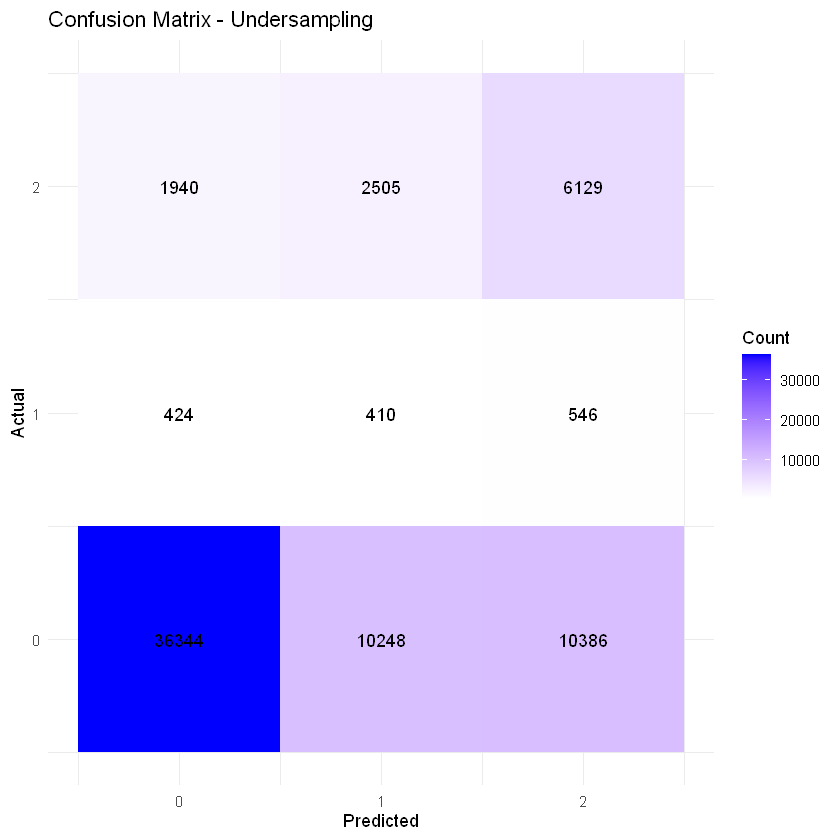

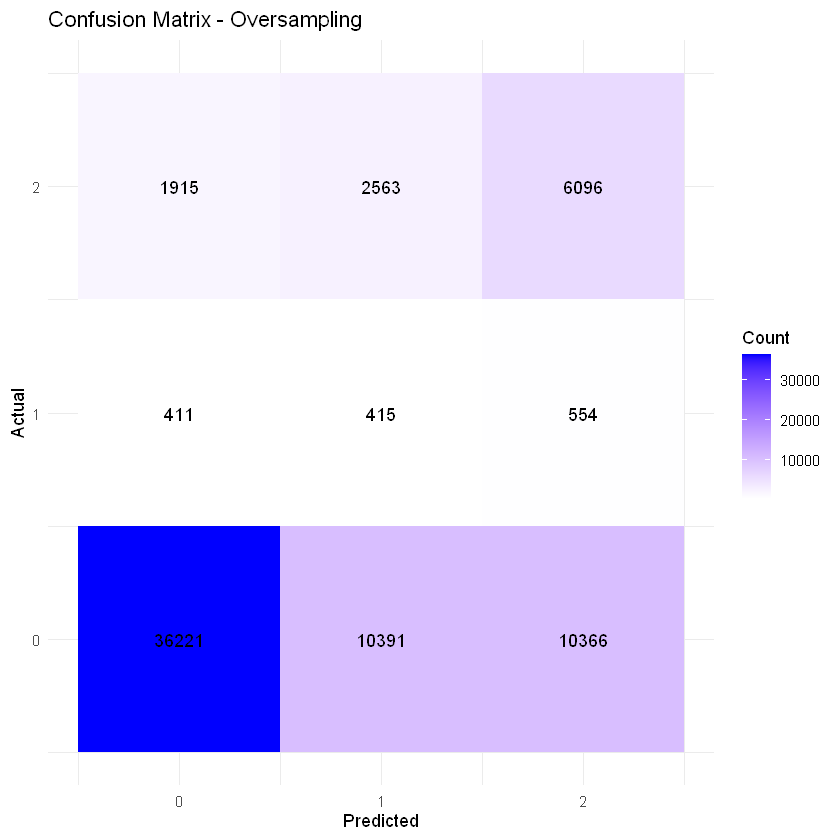

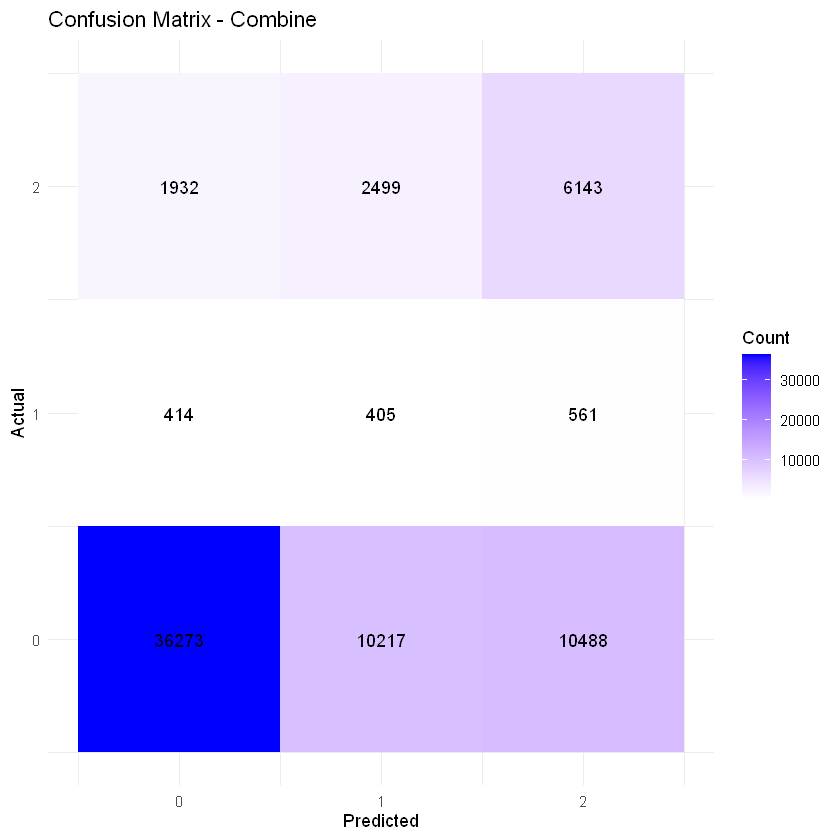

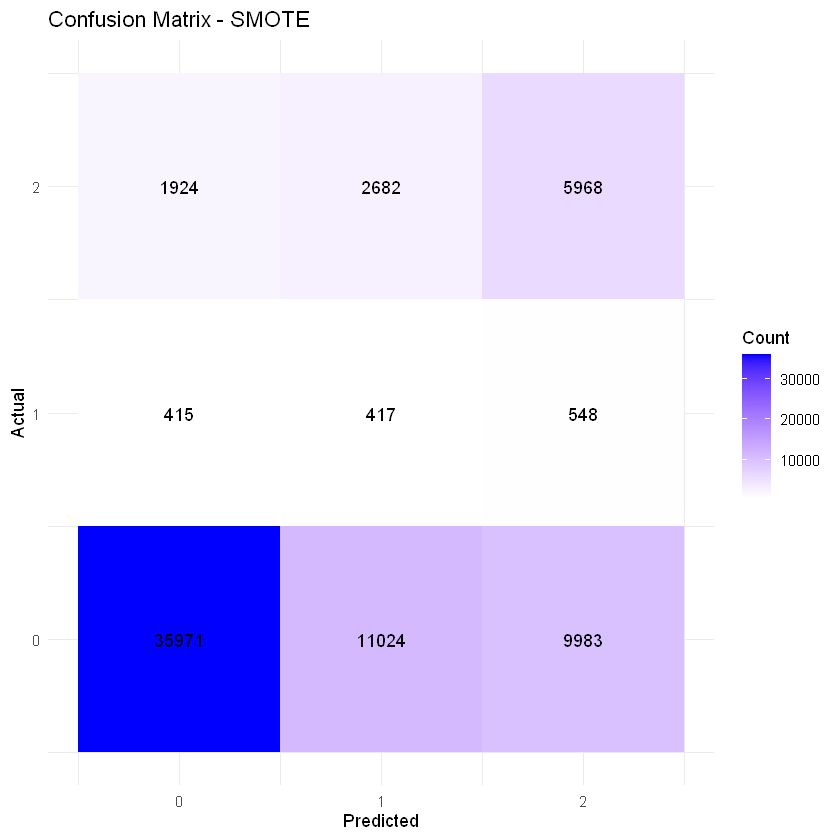

In [9]:
# vẽ trực quan confusion matrix của từng model
sampling_methods <- c("Undersampling", "Oversampling", "Combine", "SMOTE")

for (i in 1:4) {    
    cm <- first_models[[i]]$Confusion_Matrix
    cm_melt <- melt(cm)
    colnames(cm_melt) <- c("Var1", "Var2", "value")
    p <- ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
        geom_tile() +
        geom_text(aes(label = value), color = "black") +
        scale_fill_gradient(low = "white", high = "blue") +
        labs(x = "Predicted", y = "Actual", fill = "Count") +
        ggtitle(paste("Confusion Matrix -", sampling_methods[i])) +
        theme_minimal()

    print(p)
}

Nhận thấy model chạy với train_combine có vẻ cho kết quả tốt nhất trong phân loại nhóm 1 và 2.

Tiếp theo, ta sử dụng công cụ tự động lựa chọn biến để xem model tốt nhất giữ lại những biến nào. 

### Stepwise

In [10]:
full_model <- multinom(Diabetes_012 ~ ., data = train_combine, maxit = 1500)

stepwise_model <- stepAIC(full_model, direction = "both", trace = TRUE)

# weights:  69 (44 variable)
initial  value 176699.701898 
iter  10 value 168222.388751
iter  20 value 161139.910579
iter  30 value 159659.888149
iter  40 value 157322.391070
iter  50 value 155416.733671
final  value 155416.724099 
converged
Start:  AIC=310921.5
Diabetes_012 ~ HighBP + HighChol + CholCheck + BMI + Smoker + 
    Stroke + HeartDiseaseorAttack + PhysActivity + Fruits + Veggies + 
    HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + GenHlth + 
    MentHlth + PhysHlth + DiffWalk + Sex + Age + Education + 
    Income

# weights:  66 (42 variable)
initial  value 176699.701898 
iter  10 value 168903.806309
iter  20 value 162010.561449
iter  30 value 160542.097576
iter  40 value 157415.445477
final  value 156564.393883 
converged
# weights:  66 (42 variable)
initial  value 176699.701898 
iter  10 value 168672.801303
iter  20 value 161856.866041
iter  30 value 160527.886701
iter  40 value 157210.533127
final  value 156622.416358 
converged
# weights:  66 (42 variable)
initial  

In [11]:
summary(stepwise_model)

Call:
multinom(formula = Diabetes_012 ~ HighBP + HighChol + CholCheck + 
    BMI + Smoker + Stroke + HeartDiseaseorAttack + Fruits + HvyAlcoholConsump + 
    AnyHealthcare + NoDocbcCost + GenHlth + MentHlth + PhysHlth + 
    DiffWalk + Sex + Age + Education + Income, data = train_combine, 
    maxit = 1500)

Coefficients:
  (Intercept)    HighBP  HighChol CholCheck        BMI      Smoker     Stroke
1   -4.468935 0.4046287 0.5872745 0.9719947 0.05636745 -0.06661170 -0.1131593
2   -7.245141 0.7306264 0.6308964 1.3036636 0.07517994 -0.02382283  0.1373392
  HeartDiseaseorAttack      Fruits HvyAlcoholConsump AnyHealthcare NoDocbcCost
1         -0.003325027 0.037872357        -0.2910353   -0.04894954   0.3939009
2          0.198955885 0.008687722        -0.7690503    0.16434634   0.1232023
    GenHlth     MentHlth     PhysHlth    DiffWalk       Sex       Age
1 0.2739776  0.007532139 -0.004259852 -0.05888316 0.1024558 0.1344332
2 0.5711680 -0.002693967 -0.007007294  0.09448288 0.2963787 0.158

model sau stepwise vẫn giữ lại toàn bộ biến.

In [12]:
vif(stepwise_model)

Warning message in vif.default(stepwise_model):
"No intercept: vifs may not be sensible."


HighBP             HighChol            CholCheck 
            4.389062             3.885303            75.855793 
                 BMI               Smoker               Stroke 
           42.353284             3.131553             2.111450 
HeartDiseaseorAttack               Fruits    HvyAlcoholConsump 
            2.534643             3.929403             1.304911 
       AnyHealthcare          NoDocbcCost              GenHlth 
           30.549902             2.226277            22.010818 
            MentHlth             PhysHlth             DiffWalk 
            2.728200             3.872562             3.502211 
                 Sex                  Age            Education 
            2.877272            21.502316            18.366626 
              Income 
           15.864169

có đa cộng tuyến trong mô hình. 

In [13]:
prop_pred <- predict(stepwise_model, test, type = 'class')
conf_matrix <- table(test$Diabetes_012, prop_pred)
print(eval_multi_class(conf_matrix))

$Precision
         0          1          2 
0.93914192 0.03107667 0.35759623 

$Recall
        0         1         2 
0.6361929 0.2963768 0.5807641 

$Accuracy
[1] 0.6208873

$Kappa
[1] 0.2343052

$Macro_F1
[1] 0.4715058



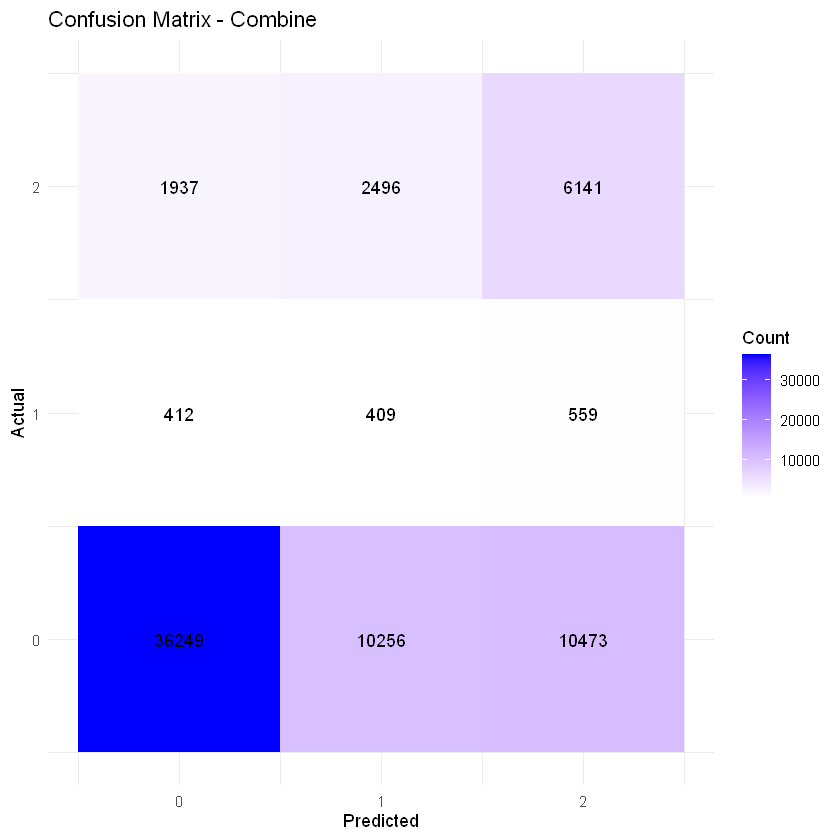

In [14]:
cm_melt <- melt(conf_matrix)
colnames(cm_melt) <- c("Var1", "Var2", "value")
ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    geom_text(aes(label = value), color = "black") +
    scale_fill_gradient(low = "white", high = "blue") +
    labs(x = "Predicted", y = "Actual", fill = "Count") +
    ggtitle("Confusion Matrix - Combine") +
    theme_minimal()

do phát hiện có đa cộng tuyến, mô hình sẽ gặp vấn đề hệ số ước lượng không ổn định nên ta sử dụng phương pháp co hệ số để giảm ảnh hưởng này. 

### Regularization

In [15]:
# xài glmnet 
model_lasso <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 1)
model_ridge <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 0)
model_enet <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 0.5)

In [16]:
# Predict and evaluate for Lasso model
pred_lasso <- predict(model_lasso, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_lasso <- table(test$Diabetes_012, pred_lasso)
cat("Confusion Matrix for Lasso Model:\n")
print(eval_multi_class(cm_lasso))

# Predict and evaluate for Ridge model
pred_ridge <- predict(model_ridge, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_ridge <- table(test$Diabetes_012, pred_ridge)
cat("\nConfusion Matrix for Ridge Model:\n")
print(eval_multi_class(cm_ridge))

# Predict and evaluate for Elastic Net model
pred_enet <- predict(model_enet, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_enet <- table(test$Diabetes_012, pred_enet)
cat("\nConfusion Matrix for Elastic Net Model:\n")
print(eval_multi_class(cm_enet))

Confusion Matrix for Lasso Model:
$Precision
         0          1          2 
0.93710002 0.02985688 0.35743178 

$Recall
        0         1         2 
0.6450560 0.2630435 0.5933422 

$Accuracy
[1] 0.6294754

$Kappa
[1] 0.2393217

$Macro_F1
[1] 0.4691228


Confusion Matrix for Ridge Model:
$Precision
         0          1          2 
0.93849805 0.03070988 0.35713871 

$Recall
        0         1         2 
0.6384745 0.2884058 0.5812370 

$Accuracy
[1] 0.6226861

$Kappa
[1] 0.2348471

$Macro_F1
[1] 0.4704679


Confusion Matrix for Elastic Net Model:
$Precision
         0          1          2 
0.93755760 0.03024968 0.35704420 

$Recall
        0         1         2 
0.6427218 0.2739130 0.5867221 

$Accuracy
[1] 0.6267481

$Kappa
[1] 0.237209

$Macro_F1
[1] 0.4694903



In [17]:
# Predict and evaluate for Ridge model on train 
pred_ridge <- predict(model_ridge, newx = as.matrix(train_combine[, -1]), s = 0.01, type = 'class')
cm_ridge <- table(train_combine$Diabetes_012, pred_ridge)
cat("\nConfusion Matrix for Ridge Model on Train set:\n")
print(eval_multi_class(cm_ridge))


Confusion Matrix for Ridge Model on Train set:
$Precision
        0         1         2 
0.5777466 0.4291457 0.5037590 

$Recall
        0         1         2 
0.6442467 0.3106150 0.5849141 

$Accuracy
[1] 0.5132586

$Kappa
[1] 0.2698879

$Macro_F1
[1] 0.5083582



Model với ridge cho kết quả tốt nhất và cũng khá gần với kết quả có được với stepwise_model.

Kết quả sau khi xây dựng mô hình tuyến tính có vẻ chưa quá khả quan trong phân loại, ta có thể nghi ngờ về quan hệ phi tuyến của các biến. Để kiểm tra thử, ta sẽ sử dụng mô hình phi tuyến là Random Forest.

### Random Forest

In [18]:
library(randomForest)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [19]:
train_combine$Diabetes_012 <- as.factor(train_combine$Diabetes_012)
set.seed(12)
rf_model <- randomForest(Diabetes_012 ~ ., data = train_combine, ntree = 100, maxnodes = 6, importance = TRUE)

In [20]:
# evaluation trên tập train
pred_rf_train <- predict(rf_model, train_combine, type = 'class')
cm_rf_train <- table(train_combine$Diabetes_012, pred_rf_train)
cat("\nConfusion Matrix for Random Forest Model on Train Set:\n")
print(eval_multi_class(cm_rf_train))


Confusion Matrix for Random Forest Model on Train Set:
$Precision
        0         1         2 
0.5556950 0.4610123 0.4375631 

$Recall
         0          1          2 
0.62781415 0.01885737 0.80044019 

$Accuracy
[1] 0.4823706

$Kappa
[1] 0.2235559

$Macro_F1
[1] 0.4835607



In [21]:
# evaluation trên tập test 
pred_rf <- predict(rf_model, test, type = 'class')
cm_rf <- table(test$Diabetes_012, pred_rf)
cat("\nConfusion Matrix for Random Forest Model:\n")
print(eval_multi_class(cm_rf))


Confusion Matrix for Random Forest Model:
$Precision
         0          1          2 
0.93415930 0.02143758 0.27971982 

$Recall
         0          1          2 
0.62327565 0.01231884 0.79686022 

$Accuracy
[1] 0.6376719

$Kappa
[1] 0.2402035

$Macro_F1
[1] 0.4422006



### Kết luận

Mặc dù model Random Forest cho recall của class 2 khá cao, tuy nhiên recall cho class 1 lại gần như bằng 0. Nếu tuning các tham số cho model thì recall cho 2 class này sẽ tương quan nghịch với nhau, nếu recall class này cao thì buộc class kia phải giảm. 

Hơn nữa, macro_F1 cũng chỉ đạt 0.45, cũng tương đương với model logistic đã xây dựng ở trên. *Điều này cho thấy cả 2 model tuyến tính và phi tuyến đều không hoạt động tốt trên tập dữ liệu*.

**Kết luận:** Có thể vấn đề nằm ở bộ dữ liệu được cung cấp không có đủ thông tin để dự đoán biến mục tiêu hoặc có chứa thông tin nhiễu. Nhất là đối với class 1, khi dữ liệu trong nhóm này rất ít so với 2 class còn lại nên việc dự đoán nhóm này rất khó dù đã có các biện pháp xử lí mất cân bằng. 

**Giải pháp:** 
1. Thu thập thêm dữ liệu những người bị tiền tiểu đường (class 1). 
2. Chuyển qua phân loại nhị phân, dự đoán 1 người bị tiểu đường hoặc không. (loại bỏ hết các quan trắc thuộc class 1 hoặc gom nhãn class 1 và 2). 

Do tính chất về mức độ bệnh và phương pháp điều trị cho người tiểu đường và tiền tiểu đường là khác nhau nên việc chuyển hướng sang phân loại nhị phân có thể không giải thích được hết vấn đề đặt ra.      
Theo khảo sát dân cư ở Mỹ thì số lượng người tiền tiểu đường nhiều hơn số lượng người tiểu đường nên việc dự đoán tiền tiểu đường cũng rất cần thiết. 